In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMRegressor
import optuna

from twws.select_variables import Selector, get_units_only
from twws.variables_list import category_columns, non_object_columns

pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('../data/data.csv')

/Users/piotr.gabrys/.local/share/virtualenvs/tww_stats-PBBeHRjs/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (617) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = get_units_only(df)

In [4]:
df.shape

(556, 620)

In [5]:
df.missile_primary__ignition_amount = df.missile_primary__ignition_amount.map({'True': 1, '0': 0, '25': 25})

In [6]:
for col in non_object_columns:
    df[col] = df[col] * 1
    df[col] = df[col].fillna(-1)

In [7]:
for col in category_columns:
    df[col] = df[col].fillna('missing')

In [8]:
df = df.loc[:, non_object_columns + category_columns + ['name']]

In [9]:
df = df.sample(frac=1)

In [10]:
df.shape

(556, 466)

In [11]:
y = df.multiplayer_cost.apply(np.log)
x = df.drop('multiplayer_cost', axis=1)

In [12]:
columns_to_remove = ['multiplayer_cost',                       
                     'speed',
                     'charge_speed', 
                     'missile_primary__total_accuracy',
                     'knock_interrupts_ignore_chance',
                     'missile_primary__reload_time',
                     'missile_primary__ammo',
                     'deceleration',
                     'unit_size',
                     'melee__ap_damage']

In [13]:
for col in columns_to_remove:
    non_object_columns.remove(col)

In [14]:
features = ["melee_defence",
"health",
"melee_attack",
"leadership",
"armour",
"health_per_entity",
"run_speed",
"missile_primary__damage",
"charge_bonus",
"melee__ap_ratio",
"melee__base_damage",
"mass",
"melee__damage",
"height",
"melee__melee_attack_interval",
"acceleration",
"melee__bonus_v_large",
"melee__bonus_v_infantry",
"melee__splash_attack_max_attacks",
"parry_chance",
"reload",
"hit_reactions_ignore_chance",
"melee__weapon_length",
"damage_mod_physical",
"accuracy",
"combat_reaction_radius",
"fly_speed",
"melee__splash_attack_power_multiplier"]

model = make_pipeline(
    Selector(features),
    LGBMRegressor(objective='mae')
)

In [15]:
def objective(trial):    
        
    lgbmregressor__num_leaves = trial.suggest_int('lgbmregressor__num_leaves', 2, 500) 
    lgbmregressor__max_depth = trial.suggest_int('lgbmregressor__max_depth', 2, 150) 
    lgbmregressor__n_estimators = trial.suggest_int('lgbmregressor__n_estimators', 10, 500) 
    lgbmregressor__subsample_for_bin = trial.suggest_int('lgbmregressor__subsample_for_bin', 2000, 500_000) 
    lgbmregressor__min_child_samples = trial.suggest_int('lgbmregressor__min_child_samples', 4, 500) 
    lgbmregressor__reg_alpha = trial.suggest_uniform('lgbmregressor__reg_alpha', 0.0, 1.0) 
    lgbmregressor__colsample_bytree = trial.suggest_uniform('lgbmregressor__colsample_bytree', 0.6, 1.0) 
    lgbmregressor__learning_rate = trial.suggest_loguniform('lgbmregressor__learning_rate', 1e-5, 1e-0)   
    

    params = {
        'lgbmregressor__num_leaves': lgbmregressor__num_leaves,
        'lgbmregressor__max_depth': lgbmregressor__max_depth,
        'lgbmregressor__n_estimators': lgbmregressor__n_estimators,
        'lgbmregressor__subsample_for_bin': lgbmregressor__subsample_for_bin,
        'lgbmregressor__min_child_samples': lgbmregressor__min_child_samples,
        'lgbmregressor__reg_alpha': lgbmregressor__reg_alpha,
        'lgbmregressor__colsample_bytree': lgbmregressor__colsample_bytree,
        'lgbmregressor__learning_rate': lgbmregressor__learning_rate
    }
    
    model.set_params(**params)
    
    cv = KFold(n_splits=8)

    return - np.mean(cross_val_score(model, x, y, cv=8, scoring='neg_median_absolute_error'))

In [16]:
study = optuna.create_study()
study.optimize(objective, n_trials=200)

[I 2020-08-31 22:20:02,350] Trial 0 finished with value: 0.14737546944923458 and parameters: {'lgbmregressor__num_leaves': 348, 'lgbmregressor__max_depth': 126, 'lgbmregressor__n_estimators': 170, 'lgbmregressor__subsample_for_bin': 423284, 'lgbmregressor__min_child_samples': 14, 'lgbmregressor__reg_alpha': 0.31969613171562405, 'lgbmregressor__colsample_bytree': 0.712877649769243, 'lgbmregressor__learning_rate': 0.8253331720972363}. Best is trial 0 with value: 0.14737546944923458.
[I 2020-08-31 22:20:02,486] Trial 1 finished with value: 0.3839822719476453 and parameters: {'lgbmregressor__num_leaves': 475, 'lgbmregressor__max_depth': 96, 'lgbmregressor__n_estimators': 453, 'lgbmregressor__subsample_for_bin': 268797, 'lgbmregressor__min_child_samples': 313, 'lgbmregressor__reg_alpha': 0.5768276503094326, 'lgbmregressor__colsample_bytree': 0.9675717653060747, 'lgbmregressor__learning_rate': 3.484436665751464e-05}. Best is trial 0 with value: 0.14737546944923458.
[I 2020-08-31 22:20:02,663

[I 2020-08-31 22:20:07,440] Trial 16 finished with value: 0.3839822719476453 and parameters: {'lgbmregressor__num_leaves': 42, 'lgbmregressor__max_depth': 75, 'lgbmregressor__n_estimators': 281, 'lgbmregressor__subsample_for_bin': 372191, 'lgbmregressor__min_child_samples': 476, 'lgbmregressor__reg_alpha': 0.029755444327460745, 'lgbmregressor__colsample_bytree': 0.8021429544747507, 'lgbmregressor__learning_rate': 0.005095235990631662}. Best is trial 10 with value: 0.11093896318438906.
[I 2020-08-31 22:20:08,026] Trial 17 finished with value: 0.35494167963789497 and parameters: {'lgbmregressor__num_leaves': 87, 'lgbmregressor__max_depth': 26, 'lgbmregressor__n_estimators': 225, 'lgbmregressor__subsample_for_bin': 203286, 'lgbmregressor__min_child_samples': 12, 'lgbmregressor__reg_alpha': 0.6472817860556166, 'lgbmregressor__colsample_bytree': 0.7822478356397299, 'lgbmregressor__learning_rate': 0.0005238039679846873}. Best is trial 10 with value: 0.11093896318438906.
[I 2020-08-31 22:20:0

[I 2020-08-31 22:20:21,796] Trial 32 finished with value: 0.10908212636728104 and parameters: {'lgbmregressor__num_leaves': 332, 'lgbmregressor__max_depth': 85, 'lgbmregressor__n_estimators': 497, 'lgbmregressor__subsample_for_bin': 170943, 'lgbmregressor__min_child_samples': 5, 'lgbmregressor__reg_alpha': 0.5689452569085387, 'lgbmregressor__colsample_bytree': 0.9616418636869709, 'lgbmregressor__learning_rate': 0.007372225941511785}. Best is trial 22 with value: 0.10143758102464762.
[I 2020-08-31 22:20:22,226] Trial 33 finished with value: 0.193060221429673 and parameters: {'lgbmregressor__num_leaves': 391, 'lgbmregressor__max_depth': 146, 'lgbmregressor__n_estimators': 427, 'lgbmregressor__subsample_for_bin': 231227, 'lgbmregressor__min_child_samples': 110, 'lgbmregressor__reg_alpha': 0.5201985956746791, 'lgbmregressor__colsample_bytree': 0.9583288018990785, 'lgbmregressor__learning_rate': 0.004996313301475787}. Best is trial 22 with value: 0.10143758102464762.
[I 2020-08-31 22:20:24,

[I 2020-08-31 22:20:37,265] Trial 48 finished with value: 0.16686137912126425 and parameters: {'lgbmregressor__num_leaves': 226, 'lgbmregressor__max_depth': 130, 'lgbmregressor__n_estimators': 400, 'lgbmregressor__subsample_for_bin': 260748, 'lgbmregressor__min_child_samples': 157, 'lgbmregressor__reg_alpha': 0.6350590538919447, 'lgbmregressor__colsample_bytree': 0.9846238905002275, 'lgbmregressor__learning_rate': 0.207260817298891}. Best is trial 42 with value: 0.09817077947944264.
[I 2020-08-31 22:20:38,167] Trial 49 finished with value: 0.10644546171227914 and parameters: {'lgbmregressor__num_leaves': 176, 'lgbmregressor__max_depth': 109, 'lgbmregressor__n_estimators': 438, 'lgbmregressor__subsample_for_bin': 349640, 'lgbmregressor__min_child_samples': 26, 'lgbmregressor__reg_alpha': 0.3872079808669471, 'lgbmregressor__colsample_bytree': 0.9390701006366634, 'lgbmregressor__learning_rate': 0.05074385674653441}. Best is trial 42 with value: 0.09817077947944264.
[I 2020-08-31 22:20:38,

[I 2020-08-31 22:21:07,263] Trial 64 finished with value: 0.11785821992573875 and parameters: {'lgbmregressor__num_leaves': 83, 'lgbmregressor__max_depth': 80, 'lgbmregressor__n_estimators': 376, 'lgbmregressor__subsample_for_bin': 469835, 'lgbmregressor__min_child_samples': 40, 'lgbmregressor__reg_alpha': 0.4904235358378077, 'lgbmregressor__colsample_bytree': 0.8722127840436769, 'lgbmregressor__learning_rate': 0.038449941591035826}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:21:08,318] Trial 65 finished with value: 0.10845655131667109 and parameters: {'lgbmregressor__num_leaves': 133, 'lgbmregressor__max_depth': 109, 'lgbmregressor__n_estimators': 404, 'lgbmregressor__subsample_for_bin': 426119, 'lgbmregressor__min_child_samples': 19, 'lgbmregressor__reg_alpha': 0.4484231424214466, 'lgbmregressor__colsample_bytree': 0.8542499621006276, 'lgbmregressor__learning_rate': 0.11635364940390742}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:21:10,

[I 2020-08-31 22:21:24,985] Trial 80 finished with value: 0.15095823105513861 and parameters: {'lgbmregressor__num_leaves': 262, 'lgbmregressor__max_depth': 125, 'lgbmregressor__n_estimators': 479, 'lgbmregressor__subsample_for_bin': 249527, 'lgbmregressor__min_child_samples': 114, 'lgbmregressor__reg_alpha': 0.8505888096279443, 'lgbmregressor__colsample_bytree': 0.9807719421228266, 'lgbmregressor__learning_rate': 0.021906137267632363}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:21:26,217] Trial 81 finished with value: 0.10191725851375644 and parameters: {'lgbmregressor__num_leaves': 133, 'lgbmregressor__max_depth': 95, 'lgbmregressor__n_estimators': 423, 'lgbmregressor__subsample_for_bin': 440290, 'lgbmregressor__min_child_samples': 16, 'lgbmregressor__reg_alpha': 0.695655093351957, 'lgbmregressor__colsample_bytree': 0.8584323860985912, 'lgbmregressor__learning_rate': 0.10444561008835838}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:21:26

[I 2020-08-31 22:21:41,937] Trial 96 finished with value: 0.3839822719476453 and parameters: {'lgbmregressor__num_leaves': 88, 'lgbmregressor__max_depth': 111, 'lgbmregressor__n_estimators': 420, 'lgbmregressor__subsample_for_bin': 479035, 'lgbmregressor__min_child_samples': 295, 'lgbmregressor__reg_alpha': 0.8021293032981747, 'lgbmregressor__colsample_bytree': 0.8165493266796165, 'lgbmregressor__learning_rate': 0.06594121667784161}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:21:42,567] Trial 97 finished with value: 0.1288736082384202 and parameters: {'lgbmregressor__num_leaves': 115, 'lgbmregressor__max_depth': 95, 'lgbmregressor__n_estimators': 428, 'lgbmregressor__subsample_for_bin': 499999, 'lgbmregressor__min_child_samples': 63, 'lgbmregressor__reg_alpha': 0.3666303699042638, 'lgbmregressor__colsample_bytree': 0.8323748348088116, 'lgbmregressor__learning_rate': 0.020219167769156512}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:21:46,2

[I 2020-08-31 22:21:58,748] Trial 112 finished with value: 0.11996558292574899 and parameters: {'lgbmregressor__num_leaves': 274, 'lgbmregressor__max_depth': 95, 'lgbmregressor__n_estimators': 463, 'lgbmregressor__subsample_for_bin': 406864, 'lgbmregressor__min_child_samples': 4, 'lgbmregressor__reg_alpha': 0.8011341197736104, 'lgbmregressor__colsample_bytree': 0.8559265956128523, 'lgbmregressor__learning_rate': 0.005529481585302766}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:22:00,117] Trial 113 finished with value: 0.11049162095235221 and parameters: {'lgbmregressor__num_leaves': 76, 'lgbmregressor__max_depth': 110, 'lgbmregressor__n_estimators': 433, 'lgbmregressor__subsample_for_bin': 477176, 'lgbmregressor__min_child_samples': 15, 'lgbmregressor__reg_alpha': 0.6908877069847447, 'lgbmregressor__colsample_bytree': 0.8064010770553216, 'lgbmregressor__learning_rate': 0.10681694020747413}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:22:01

[I 2020-08-31 22:22:33,343] Trial 128 finished with value: 0.10385758427122477 and parameters: {'lgbmregressor__num_leaves': 110, 'lgbmregressor__max_depth': 83, 'lgbmregressor__n_estimators': 467, 'lgbmregressor__subsample_for_bin': 489169, 'lgbmregressor__min_child_samples': 6, 'lgbmregressor__reg_alpha': 0.717565453225371, 'lgbmregressor__colsample_bytree': 0.8865836898306766, 'lgbmregressor__learning_rate': 0.11589658556413221}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:22:37,016] Trial 129 finished with value: 0.102221217424729 and parameters: {'lgbmregressor__num_leaves': 84, 'lgbmregressor__max_depth': 79, 'lgbmregressor__n_estimators': 442, 'lgbmregressor__subsample_for_bin': 469648, 'lgbmregressor__min_child_samples': 4, 'lgbmregressor__reg_alpha': 0.7264739853959521, 'lgbmregressor__colsample_bytree': 0.8753716831684233, 'lgbmregressor__learning_rate': 0.18202246566790092}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:22:40,552] 

[I 2020-08-31 22:23:05,714] Trial 144 finished with value: 0.10399287790484701 and parameters: {'lgbmregressor__num_leaves': 92, 'lgbmregressor__max_depth': 82, 'lgbmregressor__n_estimators': 458, 'lgbmregressor__subsample_for_bin': 499435, 'lgbmregressor__min_child_samples': 13, 'lgbmregressor__reg_alpha': 0.7733775818202906, 'lgbmregressor__colsample_bytree': 0.9123162430894676, 'lgbmregressor__learning_rate': 0.07463493113051616}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:23:09,905] Trial 145 finished with value: 0.09953132684948729 and parameters: {'lgbmregressor__num_leaves': 104, 'lgbmregressor__max_depth': 74, 'lgbmregressor__n_estimators': 500, 'lgbmregressor__subsample_for_bin': 474993, 'lgbmregressor__min_child_samples': 4, 'lgbmregressor__reg_alpha': 0.6991882753553844, 'lgbmregressor__colsample_bytree': 0.882155360673653, 'lgbmregressor__learning_rate': 0.05199892775583941}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:23:14,28

[I 2020-08-31 22:23:53,708] Trial 160 finished with value: 0.10493025764227493 and parameters: {'lgbmregressor__num_leaves': 70, 'lgbmregressor__max_depth': 72, 'lgbmregressor__n_estimators': 452, 'lgbmregressor__subsample_for_bin': 463781, 'lgbmregressor__min_child_samples': 4, 'lgbmregressor__reg_alpha': 0.6945916616900887, 'lgbmregressor__colsample_bytree': 0.8931310604213937, 'lgbmregressor__learning_rate': 0.09584663802015543}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:23:57,293] Trial 161 finished with value: 0.10308488334467092 and parameters: {'lgbmregressor__num_leaves': 101, 'lgbmregressor__max_depth': 83, 'lgbmregressor__n_estimators': 431, 'lgbmregressor__subsample_for_bin': 471454, 'lgbmregressor__min_child_samples': 4, 'lgbmregressor__reg_alpha': 0.7302743461884856, 'lgbmregressor__colsample_bytree': 0.8775801245234965, 'lgbmregressor__learning_rate': 0.1599967157148039}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:23:58,930

[I 2020-08-31 22:24:28,048] Trial 176 finished with value: 0.10444363515952798 and parameters: {'lgbmregressor__num_leaves': 139, 'lgbmregressor__max_depth': 61, 'lgbmregressor__n_estimators': 455, 'lgbmregressor__subsample_for_bin': 447547, 'lgbmregressor__min_child_samples': 4, 'lgbmregressor__reg_alpha': 0.7980721676704613, 'lgbmregressor__colsample_bytree': 0.9998947260895485, 'lgbmregressor__learning_rate': 0.07648445441452692}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:24:31,770] Trial 177 finished with value: 0.10036683239000804 and parameters: {'lgbmregressor__num_leaves': 63, 'lgbmregressor__max_depth': 56, 'lgbmregressor__n_estimators': 494, 'lgbmregressor__subsample_for_bin': 456443, 'lgbmregressor__min_child_samples': 4, 'lgbmregressor__reg_alpha': 0.681614556315319, 'lgbmregressor__colsample_bytree': 0.9163231369230332, 'lgbmregressor__learning_rate': 0.14032216775636597}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:24:32,954

[I 2020-08-31 22:24:52,621] Trial 192 finished with value: 0.10092880860074421 and parameters: {'lgbmregressor__num_leaves': 23, 'lgbmregressor__max_depth': 41, 'lgbmregressor__n_estimators': 485, 'lgbmregressor__subsample_for_bin': 26768, 'lgbmregressor__min_child_samples': 4, 'lgbmregressor__reg_alpha': 0.9745527048736365, 'lgbmregressor__colsample_bytree': 0.9485071745622431, 'lgbmregressor__learning_rate': 0.05108843551646052}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:24:54,145] Trial 193 finished with value: 0.10341792754523726 and parameters: {'lgbmregressor__num_leaves': 25, 'lgbmregressor__max_depth': 49, 'lgbmregressor__n_estimators': 500, 'lgbmregressor__subsample_for_bin': 476910, 'lgbmregressor__min_child_samples': 15, 'lgbmregressor__reg_alpha': 0.4016430818166097, 'lgbmregressor__colsample_bytree': 0.9487781864577318, 'lgbmregressor__learning_rate': 0.05145773295163452}. Best is trial 57 with value: 0.09652855418926393.
[I 2020-08-31 22:24:55,022

In [17]:
features = ["melee_defence",
"health",
"melee_attack",
"leadership",
"armour",
"health_per_entity",
"run_speed",
"missile_primary__damage",
"charge_bonus",
"melee__ap_ratio",
"melee__base_damage",
"mass",
"melee__damage",
"height",
"melee__melee_attack_interval",
"acceleration",
"melee__bonus_v_large",
"melee__bonus_v_infantry",
"melee__splash_attack_max_attacks",
"parry_chance",
"reload",
"hit_reactions_ignore_chance",
"melee__weapon_length",
"damage_mod_physical",
"accuracy",
"combat_reaction_radius",
"fly_speed",
"melee__splash_attack_power_multiplier"]

model = make_pipeline(
    Selector(features),
    LGBMRegressor(objective='mae')
)

best_params = {'lgbmregressor__num_leaves': 434,
 'lgbmregressor__max_depth': 110,
 'lgbmregressor__n_estimators': 256,
 'lgbmregressor__subsample_for_bin': 82449,
 'lgbmregressor__min_child_samples': 4,
 'lgbmregressor__reg_alpha': 0.14126751650012037,
 'lgbmregressor__colsample_bytree': 0.7745213812855362,
 'lgbmregressor__learning_rate': 0.04242070860113767}

model.set_params(**best_params)

Pipeline(steps=[('selector',
                 <twws.select_variables.Selector object at 0x131b4be50>),
                ('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.7745213812855362,
                               learning_rate=0.04242070860113767, max_depth=110,
                               min_child_samples=4, n_estimators=256,
                               num_leaves=434, objective='mae',
                               reg_alpha=0.14126751650012037,
                               subsample_for_bin=82449))])

In [28]:
cv = KFold(n_splits=8)

ys = []
yhats = []
xs = []
for train_index, test_index in cv.split(x):
    x_train, x_test = x.iloc[train_index, :], x.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(x_train, y_train)
    yhat = model.predict(x_test)
    ys.append(y_test.values)
    yhats.append(yhat)
    xs.append(x_test.name.values)
    print(np.median(np.abs((yhat - y_test.values))), np.median(np.abs((np.exp(yhat) - np.exp(y_test.values)))))

ys = np.concatenate(ys)
yhats = np.concatenate(yhats)
xs = pd.DataFrame(np.concatenate(xs), columns=['name'])

xs['yhat'] = np.exp(yhats).reshape(-1, 1)
xs['y'] = np.exp(ys).reshape(-1, 1)
xs['res'] =  xs.yhat - xs.y
xs['res_perc'] = xs.yhat / xs.y - 1

xs.sort_values(by='res_perc', ascending=False, inplace=True)

0.10286667457071186 80.474515325337
0.08889552539397405 59.492918219037335
0.10855460714420495 83.90862299254013
0.1181555395152496 99.57712932134118
0.10525263584371469 100.05377391017885
0.09132697837402581 72.75645094302126
0.10249711312229426 91.14735363981356
0.09214808467456237 78.13196470080993


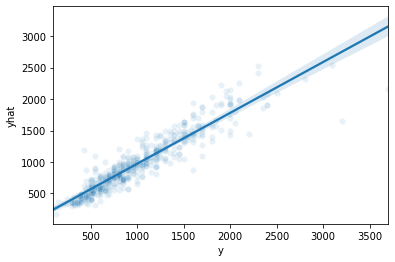

In [29]:
sns.regplot(xs.y, xs.yhat, scatter=False)
sns.scatterplot(xs.y, xs.yhat, alpha=0.1);

In [30]:
np.abs(xs.res).median()

88.08959167436598

In [31]:
xs

,name,yhat,y,res,res_perc
473,Zombies,295.368219,100.0,195.368219,1.953682
239,Bloated Corpse,1198.118992,425.0,773.118992,1.819104
173,Peasant Mob,269.157174,100.0,169.157174,1.691572
81,Spider Hatchlings,367.004692,150.0,217.004692,1.446698
293,Aspiring Champions,1097.863696,550.0,547.863696,0.996116
245,Feral Cold Ones,869.553560,450.0,419.553560,0.932341
300,Skavenslave Spears,281.611479,150.0,131.611479,0.877410
434,The Tithe (Zombies),341.750263,200.0,141.750263,0.708751
431,Corpse Cart,408.852646,250.0,158.852646,0.635411
238,Warpfire Throwers,899.088409,550.0,349.088409,0.634706
